In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

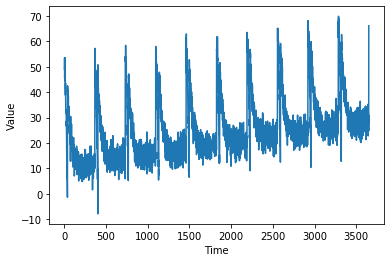

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, 365, amplitude)
# update with the noise
series += noise(time, noise_level=noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x*10.0)
])

In [6]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(
    loss= tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics=["mae"]
)

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 1s 11ms/step - loss: 22.5985 - mae: 23.0983 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 22.5004 - mae: 23.0003 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 22.3765 - mae: 22.8763 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 1s 10ms/step - loss: 22.2227 - mae: 22.7225 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 22.0484 - mae: 22.5482 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 1s 9ms/step - loss: 21.8843 - mae: 22.3841 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 1s 8ms/step - loss: 21.7508 - mae: 22.2506 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 1s 8ms/step - loss: 21.6415 - mae: 22.1413 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 1s 8ms/step - loss: 21.5431 - mae: 22.043

[1e-08, 0.0001, 0, 30]

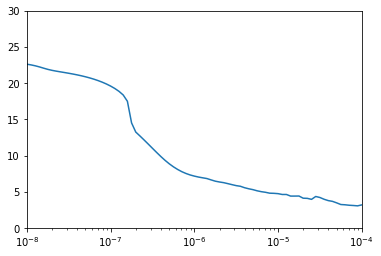

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  # YOUR CODE HERE
  tf.keras.layers.Lambda(lambda x: x*100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

======] - 1s 9ms/step - loss: 19.6608 - mae: 2.9765
Epoch 297/500
94/94 [==============================] - 1s 9ms/step - loss: 21.5185 - mae: 3.1188
Epoch 298/500
94/94 [==============================] - 1s 9ms/step - loss: 20.0247 - mae: 2.9898
Epoch 299/500
94/94 [==============================] - 1s 9ms/step - loss: 20.6907 - mae: 3.0834
Epoch 300/500
94/94 [==============================] - 1s 9ms/step - loss: 20.1575 - mae: 3.0018
Epoch 301/500
94/94 [==============================] - 1s 9ms/step - loss: 19.8291 - mae: 2.9682
Epoch 302/500
94/94 [==============================] - 1s 9ms/step - loss: 20.2225 - mae: 2.9935
Epoch 303/500
94/94 [==============================] - 1s 9ms/step - loss: 20.2512 - mae: 3.0097
Epoch 304/500
94/94 [==============================] - 1s 9ms/step - loss: 20.7094 - mae: 3.0655
Epoch 305/500
94/94 [==============================] - 1s 9ms/step - loss: 21.7470 - mae: 3.1606
Epoch 306/500
94/94 [==============================] - 1s 9ms/step - loss: 

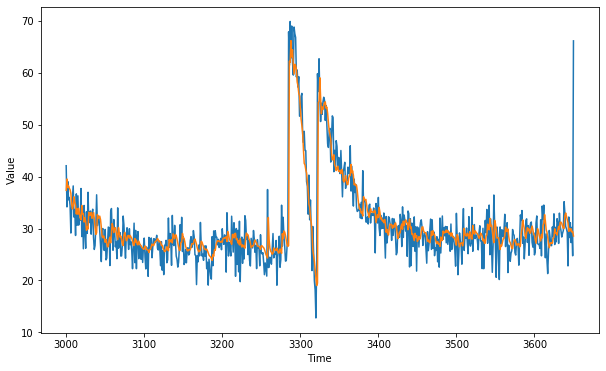

In [10]:
forecast = []
results = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9205344

<Figure size 432x288 with 0 Axes>

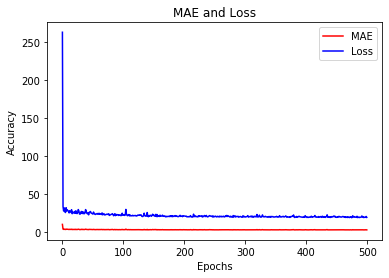

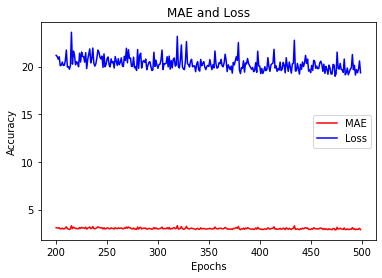

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()